In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random 
import kaggle

## Data Extraction
The first step in the project is to gather the data from online resources. For this project we will be using dataset from FER2013 which was a dataset released for a kaggle competition. Source: ##link to the data
- Download data from Kaggle
- Convert CSV to Dataframe

In [4]:
#Downloading Data
# Set the Kaggle dataset and file details
kaggle_dataset = 'deadskull7/fer2013'  # Example: 'zillow/zecon'
file_name = 'fer2013.csv'  # Name of the file you want to download
data_folder = '../data'

# Create data directory if it does not exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(os.path.join(data_folder, file_name)):
    try:
        # Download the dataset file from Kaggle
        kaggle.api.dataset_download_files(dataset=kaggle_dataset, unzip =True, path=data_folder)
        print('Data downloaded and extracted.')

    except Exception as e:
        print(f"An error occurred: {e}")


In [15]:
##import the csv file obtained and convert it into a pandas dataframe
faces = pd.read_csv('../data/fer2013.csv')
#faces.head allows you to see top five rows of the dataframe. 
# if you want more you can specify the number as parameter
faces.head()
# use faces.tail to get the last five rows

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Data Exploration

In [10]:
# Dataframe.info() method allows us to see the features of the dataset.
# This includes their name, count and data type
faces.info()

#there is a method for dataframe called describe() which lets us get statistical analysis on the numerical features of the dataset. 
# For our dataset, we only have one int datatype feature. So we wont be using it
# This method provides information about the min, max, avg, q3, q4,etc.which can be essential for some other analysis.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [9]:
#Dataframe.nunique() gives us the total number of unique values in all the features of the dataset. 
faces.nunique()

emotion        7
pixels     34034
Usage          3
dtype: int64

## Dataset Description
The given dataset has 3 features which are:
- Emotion: Label encoded feature with 7 different emotions.
    - 0: Angry
    - 1: Digust
    - 2: Fear
    - 3: Happy
    - 4: Sad
    - 5: Surprise
    - 6: Neutral 
- Pixels: This is a flattened array of pixels of a black and white 48x48 pixels face picture in string format
- Usage: Label for the picture whether to use them as training or testing or validation.

For our classififcation, we will be generalizing faces into total four categories happy, sad, calm and angry. This will help us in easier recommendation of the music as there is no music that can be helpful for example surprised emotion. We will make a subset of the dataset containing only these 4 emotions and use them for further processes.

In [16]:
#making subset of dataframe
faces = faces[faces['emotion'].isin([0,3,4,6])].reset_index(drop=True)

In [13]:
#value_counts give the total number of discrete values in a column
faces['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
0    4953
Name: count, dtype: int64

Initial Mapping
- 0: Angry
- 1: Digust
- 2: Fear
- 3: Happy
- 4: Sad
- 5: Surprise
- 6: Neutral 

Lets map such that:
- 0 : Anger
- 1 : Happy
- 2 : Sad
- 3 : Neutral

In [18]:
## !! MAKE SURE YOU DONT REPLACE TWICE !!
faces['emotion'].replace({3:1,4:2,6:3},inplace= True)
faces['emotion'].value_counts() 

emotion
1    8989
3    6198
2    6077
0    4953
Name: count, dtype: int64

In [26]:
# Lets see how many of them are in training and testing
faces.groupby('Usage')['emotion'].value_counts()

Usage        emotion
PrivateTest  1           879
             3           626
             2           594
             0           491
PublicTest   1           895
             2           653
             3           607
             0           467
Training     1          7215
             3          4965
             2          4830
             0          3995
Name: count, dtype: int64

The classes are evenly distributed except the happy class in training

In [30]:
def get_pix(str_pix):
    img = np.array(str_pix.split(),dtype =float) 
    #this will give a list from the string for instance [233,181,135]. 
    #pixels.split() gives a list and np.array converts the list to array
    # For the neural network, the neural networks wants an extra dimension for the color space like rgb or grayscale. Lets add that
    img = img.reshape(48,48,1) # reshape the 1d array to 2d array of dimensions 48x48x1
    return img.astype(np.uint8) #return tuple of img with required datatype and emotion label

In [31]:
# apply this get_pix funtion throughout the dataframe where all the pixels that are in string format is converted into an array of shape 48,48,1
faces['pixels'] = faces['pixels'].apply(lambda x: get_pix(x))

In [32]:
faces.head(3)

,emotion,pixels,Usage
0,0,"[[[70], [80], [82], [72], [58], [58], [60], [6...",Training
1,0,"[[[151], [150], [147], [155], [148], [133], [1...",Training
2,2,"[[[24], [32], [36], [30], [32], [23], [19], [2...",Training


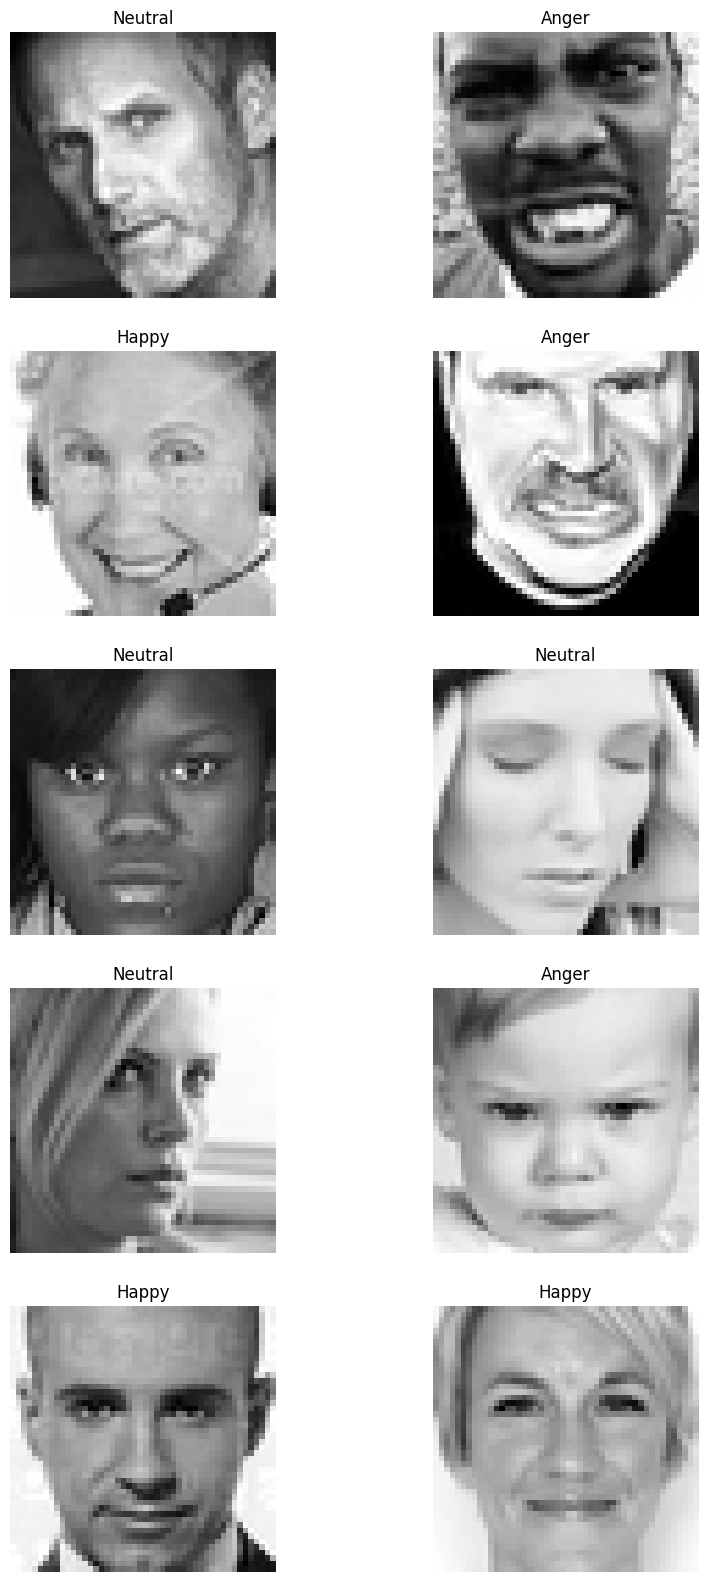

In [35]:
#Lets check some of the faces from our dataset now they are in required array format.
# We can use matplotlib to plot the pixel values
samples = faces.sample(n = 10).reset_index() #getting 10 random samples
emotion_map = {0:'Anger',1:'Happy',2:'Sad',3:'Neutral'} # making a dictionary to  map the labels 
plt.figure(0, figsize=(10,20))
for index, row in samples.iterrows():
    plt.subplot(5,2,index+1) 
    plt.imshow(row['pixels'],cmap='gray')
    plt.title(emotion_map[row['emotion']])
    plt.axis('off')
plt.show() 